# Making LoL_Win_Predict_Big Static

# Purpose of This Project
## Background
This is my first coding project and its purpose is simply to practice some of the concepts I have learned on Codecademy. My academic background is a BASc in Nanotechnology Engineering, where the limited amount of programming done was computational. I learned near the end of my degree that I enjoyed computer science and specifically wanted to spend some time learning the basics/fundamentals of data science and machine learning.

## League of Legends
To keep me motivated and interested, I decided to work with real-world data that I personally have an interest in.

League of Legends (LoL) is a highly popular multiplayer online battle arena (MOBA) video game developed and published by Riot Games. In LoL, players assume the role of a "champion," each with unique abilities, and compete in teams to destroy the opposing team's base while defending their own.

There are many reasons why League of Legends makes a good data science project:

Vast Amount of Data: League of Legends generates an enormous amount of data every day, including gameplay statistics, match results. This data can be collected from the game's API, online repositories, or directly from the game itself.

Complexity: The game is highly complex, with numerous variables influencing the outcome of matches. These variables include champion picks, item builds, player skill levels, team compositions, and neutral objectives.

Predictive Analytics: With access to historical match data, one can build predictive models to forecast match outcomes, player performance, or even trends in the meta (the most effective strategies and champion picks at a given time).

## Riot API
All the data used in this project was extracted from Riot APIs and stored in a parquet file. There are a few reasons as to why I did this:

First, when requesting data from their APIs, it requires the use of my personal API key tied to my Riot Games account. This key should not be shared with the public and would required some (potentially non-existant) method that I have not currently looked into to keep it hidden and the code still publicly accessible.

Second, this project uses player match histories to attempt to predit the outcome of the game. This dataset changes every time a request is made, making it diffcult to have reproducible results when working on the machine learning models.

Third, there is a limit to the amount of requests that can be made every minute so gathering the data for a larger dataset takes a long time. For example, the models in this project are trained on 500 matches, totalling over 500 requests, which takes over 10 minutes to accomplish.

More information on how the data was collected can be found in the following sections of LoL_Win_Predict_Big.ipynb:
1. Get user PUUID using their Riot ID and Tagline
2. Get user match history (past 50 games)
3. Get match information
4. Extract desired user stats for every match using their PUUID

## Required Libraries
- pyarrow
- pandas
- seaborn
- matplotlib
- numpy
- sklearn
- scipy
- dtale (used but optional - easier DataFrame viewing in Jupyter Notebook)

In [3]:
# Importing required libraries
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dtale

# ML related libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, LeaveOneOut
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from scipy.stats import chi2_contingency

## Using static DataFrame to no longer need Riot API key
The file imported was generated in LoL_Win_Predict_Big.ipynb. Using a static dataframe makes testing more consistent and removes the need to request data from Riot Games, removing the need of my personal API key (which should not be shared with the public).

More information on how the data was collected can be found there in the following sections of LoL_Win_Predict_Big.ipynb:

1. Get user PUUID using their Riot ID and Tagline
2. Get user match history (past 50 games)
3. Get match information
4. Extract desired user stats for every match using their PUUID

Edit 2024/03/20:

I decided to add the results from the blue team and the red team giving a total of 1000 samples. I was previously only using the results from the blue team because the features being used reflected the results for both teams. For example, if the blue team gets the first kill (value of True in the table), the values must be Flase for the red team. Now however, I have inlcuded new features such as number of dragon kills (as dummy variables), which makes it such that the results of the blue team's objectives is not perfectly reflected in the red team's, creating new and useful data to train on.

In [5]:
file_path = 'objectives_data.parquet.gzip'

class WinPredictionTrainingPipeline:
    def __init__(self, file_path, target_name):
        """
        Initialize WinPredictionTrainingPipeline.

        Args:
            file_path (str): The file path to the dataset.
            target_name (str): Name of the target column.
        """
        self.file_path = file_path
        self.target_name = target_name
        self.data = None
        self.X_data = None
        self.y_data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None    
        
    def read_parquet_file(self):
        """Load dataset from file path with file extension .parquet.gzip."""
        self.data = pq.read_table(self.file_path)

    def parquet_to_pandas(self):
        """Convert parquet table to pandas dataframe."""
        self.data = self.data.to_pandas()

    def get_categorical_features(self):
        """Keep only categorical features from dataset."""
        self.data = self.data.select_dtypes(include='bool')

    def clean_data(self):
        """Remove columns which contain missing values."""
        self.data = self.data.dropna(axis=1)
            
    def feature_target_split(self):
        """Separate features from target variables."""
        self.X_data = self.data.drop(self.target_name, axis=1)
        self.y_data = self.data[self.target_name]

    def get_data(self):
        """Returns a copy of the dataset."""
        return self.data.copy()

    def set_X_data(self, X_data):
        """Update X_data."""
        self.X_data = X_data

    def set_y_data(self, y_data):
        """Update y_data."""
        self.y_data = y_data
        
    def get_X_data(self):
        """Returns a copy of X_data."""
        return self.X_data.copy()

    def get_y_data(self):
        """Returns a copy of y_data."""
        return self.y_data.copy()
        
    def train_test_split(self, test_size=0.2, random_state=42):
        """Split arrays or matrices into random train and test subsets."""
        self.X_train, self.X_test, self.y_train, self.y_test =\
        train_test_split(self.X_data, self.y_data, test_size=test_size, random_state=random_state)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def model_testing(self, model_dict):
        """
        Test various machine learning algorithms on dataset. These models should follow the 
        training and predicting methods of sklearn's .fit and .predict.

        Args:
            model_dict (dict): Contains a dictionary of machine learning algorithms.
            The keys are the names of the models stored as strings, and the values are the functions.
            Has format {"modelName": model_function}.

        Returns:
            model_scores (pandas DataFrame): Dataframe containing the true negatives, false positives,
            false negatives, true positives of each model as well as their accuracy, precision, recall, and f1 score.
        """
        model_scores = {}
    
        for model_name, model_func in model_dict.items():
        
            print(f'\n#===================== {model_name} =====================#')
            model = model_func()
            model.fit(self.X_train, self.y_train)
        
            y_pred = model.predict(self.X_test)
        
            # Create confusion matrix comparing the predicted outcomes to the real outcomes
            confusion_mat = confusion_matrix(self.y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(self.y_test, y_pred).ravel()
        
            print('Confusion Matrix:')
            print(confusion_mat)

            # Accuracy score
            accuracy = accuracy_score(self.y_test, y_pred)
            print(f'\nAccuracy Score: {accuracy}')

            # Precision score
            precision = precision_score(self.y_test, y_pred)
            print(f'Precision Score: {precision}')

            # Recall Score
            recall = recall_score(self.y_test, y_pred)
            print(f'Recall Score: {recall}')

            # F1 Score
            f1 = f1_score(self.y_test, y_pred)
            print(f'F1 Score: {f1}')
        
            model_scores[model_name] = {'tn, fp, fn, tp': [tn, fp, fn, tp],\
                                              'accuracy': accuracy,\
                                              'precision': precision,\
                                              'recall': recall,\
                                              'f1': f1}
        
        model_scores = pd.DataFrame(model_scores)
        
        return model_scores
        
    def k_fold_cv(self, model_dict, n_folds):
        """
        Similar to model_testing but more robust and computationally expensive. Performs K-fold cross-validation.

        Args:
            model_dict (dict): Contains a dictionary of machine learning algorithms.
            The keys are the names of the models stored as strings, and the values are the functions.
            Has format {"modelName": model_function}.

            n_folds (int): Number of folds. Must be at least 2.

        Returns:
            model_scores (pandas DataFrame): Dataframe containing the average accuracy, precision, recall, and f1 score
            accross all folds.
        """    
        # Extract features and target as NumPy arrays
        X = self.X_data.values
        y = self.y_data.values
    
        # Initialize KFold
        kf = KFold(n_splits=n_folds)
    
        # Store score functions in dictionary for easier looping
        metric_functions = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}
    
        # Will store predicted target variables for each model
        model_pred = {}
    
        # Dictionary that will summarize all of the scores
        metrics_dict = {}
        
        for model_name in model_dict:
            metrics_dict[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    
        # Split the data using KFold and train on our models
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Train models and store predictions
            for model_name, model_func in model_dict.items():
                # Create model
                model = model_func()
                
                # Fit model
                model.fit(X_train, y_train)
    
                # Store prediction
                model_pred[model_name] = model.predict(X_test)
    
            # Add metrics to dictionary
            # Loop through every model name
            for model_name in metrics_dict:
                # Loop through every metric function
                for metric_name in metric_functions:
                    # Predicted values for current model
                    y_pred = model_pred[model_name]
    
                    # Apply corresponding score function
                    score = metric_functions[metric_name](y_test, y_pred)
    
                    # Append score to list for corresponding model and metric
                    metrics_dict[model_name][metric_name].append(score)
    
        model_scores = pd.DataFrame(metrics_dict)
    
        # Round the values to 2 decimal points
        model_scores = model_scores.map(lambda x: [round(num, 2) for num in x])
    
        # Add the mean of each score for each model
        for model_name in model_dict:
            model_scores[f'{model_name} Mean'] = model_scores[model_name].apply(lambda row: np.mean(row))
    
    
        return model_scores

In [42]:
win_predict = WinPredictionTrainingPipeline(file_path, 'win')
win_predict.read_parquet_file()
win_predict.parquet_to_pandas()
win_predict.get_categorical_features()
win_predict.clean_data()
win_predict.feature_target_split()

data = win_predict.get_data()
X_data = win_predict.get_X_data()
y_data = win_predict.get_y_data()

## Feature-Target Relationship
### Chi2 Contingency
Viewing the strength of the relationship between features and winning. We can immediately see that hordeKills_2 has no impact on the results and can be removed.

In [8]:
def features_chi2(X_data):
    # Create a contingency table
    chi2_list = []
    pval_list = []

    # Checking the association between each X variable and the target variable
    for col in X_data:
        contingency_table = pd.crosstab(X_data[col], y_data)
        chi2_val, pval, _, _ = chi2_contingency(contingency_table)
        chi2_list.append(chi2_val)
        pval_list.append(pval)

    chi2_df = pd.DataFrame({'feature': X_data.columns, 'chi2': chi2_list, 'pval': pval_list})

    chi2_df = chi2_df.sort_values(by = 'chi2', ascending = False).reset_index(drop=True)
    return chi2_df

chi2_df = features_chi2(X_data)

print(chi2_df)

             feature        chi2           pval
0   inhibitorKills_0  462.401850  1.442814e-102
1     inhibitorFirst  404.481476   5.826224e-90
2         baronFirst  202.349276   6.414782e-46
3         towerFirst  152.187660   5.765163e-35
4   inhibitorKills_2  114.987399   7.919913e-27
5      dragonKills_0   87.822719   7.159191e-21
6      dragonKills_4   76.153997   2.623836e-18
7   inhibitorKills_3   73.550212   9.810839e-18
8   inhibitorKills_1   73.339998   1.091338e-17
9    riftHeraldFirst   64.229649   1.107298e-15
10     championFirst   33.128771   8.625297e-09
11     dragonKills_1   28.169186   1.111603e-07
12     dragonKills_3   17.934962   2.285832e-05
13      hordeKills_6   16.604528   4.604097e-05
14      hordeKills_0   13.756339   2.081173e-04
15        hordeFirst   13.620812   2.236919e-04
16  inhibitorKills_4   12.451968   4.175517e-04
17     dragonKills_5   10.734248   1.051707e-03
18     dragonKills_2   10.706129   1.067812e-03
19       dragonFirst    4.407408   3.578

### Pearson Correlation Heat Map
The first thing I notice in the heat map is that riftHeraldFirst and riftHeraldKills are perfectly collinear; They represent the exact same data. The reson for the collinearity is due to the fact that it used to be possible to kill more than one rift herald in a game, making the features different. However as of 2024/03/20, there is only one rift herald per game, making the first team to kill one be the only team to do so.

I will also investigate the impact of keeping/removing the inhibitorKills_0 feature.

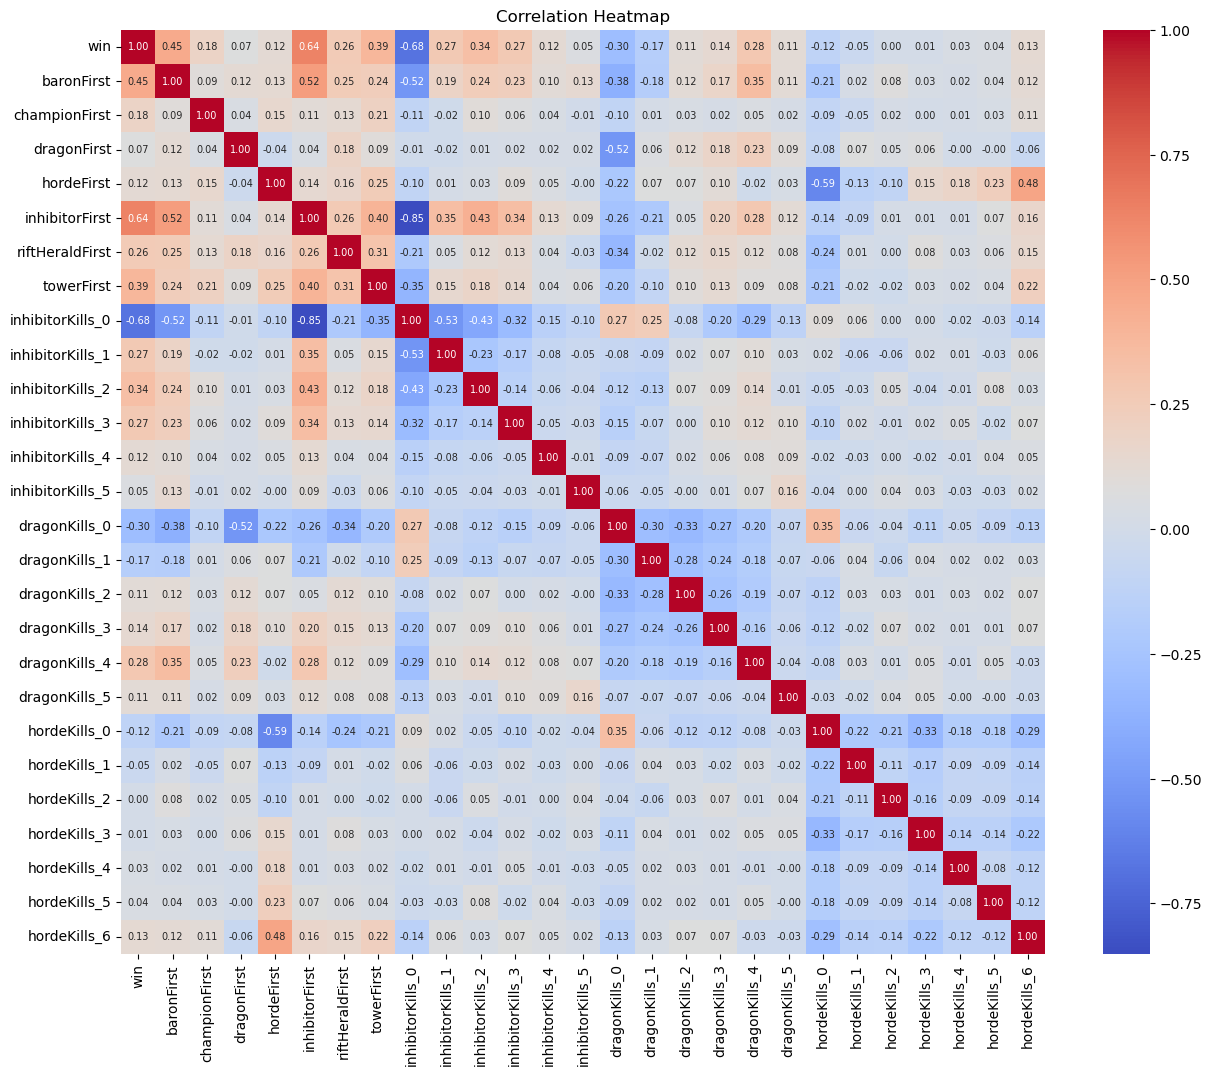

<Figure size 640x480 with 0 Axes>

In [10]:
# Correlation matrix
corr_matrix = data.corr()

# Plot heat map
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, annot_kws={"fontsize": 7})
plt.title('Correlation Heatmap')
plt.show()
plt.clf()

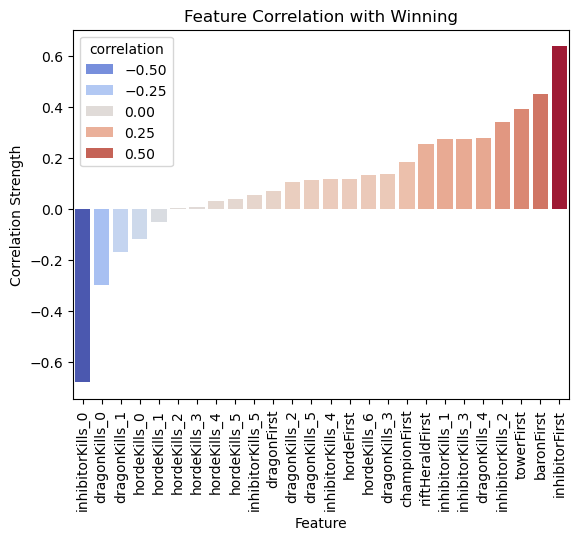

<Figure size 640x480 with 0 Axes>

In [52]:
# Correlation with target
feature_target_corr = pd.DataFrame({'feature': X_data.columns, 'correlation': corr_matrix['win'][1:]})
feature_target_corr = feature_target_corr.sort_values(by='correlation')

# Plot positive values in red and negative values in blue
sns.barplot(x=feature_target_corr['feature'], 
            y=feature_target_corr['correlation'], 
            hue=feature_target_corr['correlation'], 
            palette='coolwarm')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Correlation Strength')
plt.title('Feature Correlation with Winning')
plt.show()
plt.clf()

## Check if Feature Trimming is Necessary
We are verifying if removing the features that have a pval greater than 0.05 with relatively low chi2 values will positively impact our model performance. Even though judging the **practical** significance of a feature solely based on its **statistical** significance is ill-advised, in our case it is relatively easy to test the two cases manually and compare the results.

It is worth noting that the significance of these features will likely change with smaller and larger datasets, especially if the dataset uses player matches with a different rank distribution than ours. This is due to the fact that at different skill levels/ranks, the priority, impact, and capability of objectives to carry over to a win can vary drastically. This relationship may be looked into further in a separate project.

In [13]:
# Removing excess features (commented out as it was only used for testing)
X_data.pop('hordeKills_2')
win_predict.set_X_data(X_data)

# Selecting a Machine Learning Model

## Using sklearn machine learning libraries
### Supervised Learning Algorithms

Since the data we are working with is labelled with wins and losses, it makes the most sense to use a supervised learning algorithm.

Models Tested:
- Logistic Regression
- K Nearest Neighbour
- Decision Tree
- Random Forest
- Gradient Boosting

## Machine Learning Model Metrics
Due to the nature of League of Legends, a player's win/loss ratio should be close to 50%, meaning the target variable "win" is well balanced. So, accuracy acts as a simple yet useful indicator of the effectiveness of our machine learning models and will be the primary metric taken into consideration when choosing a model. The win/loss ratio of this dataset, coincidentally, came out to exactly 50% (500/1000).

Confusion Matrix = [[TN, FP], [FN, TP]]

**Accuracy = (TP + TN)/(TP + FP + TN + FN)**

Precision = TP/(TP + FP)

Recall = TP/(TP + FN)

F1 score: weighted average of precision and recall## Model Testing

In [15]:
win_predict.train_test_split()

model_dict = {'logisticRegression': LogisticRegression, 
              'kNearestNeighbour': KNeighborsClassifier,
              'decisionTreeClassifier': DecisionTreeClassifier,
              'randomForestClassifier': RandomForestClassifier,
              'gradientBoostingClassifier': GradientBoostingClassifier}

metric_scores = win_predict.model_testing(model_dict)


#===================== logisticRegression =====================#
Confusion Matrix:
[[79 14]
 [27 80]]

Accuracy Score: 0.795
Precision Score: 0.851063829787234
Recall Score: 0.7476635514018691
F1 Score: 0.7960199004975125

#===================== kNearestNeighbour =====================#
Confusion Matrix:
[[74 19]
 [25 82]]

Accuracy Score: 0.78
Precision Score: 0.8118811881188119
Recall Score: 0.7663551401869159
F1 Score: 0.7884615384615384

#===================== decisionTreeClassifier =====================#
Confusion Matrix:
[[68 25]
 [23 84]]

Accuracy Score: 0.76
Precision Score: 0.7706422018348624
Recall Score: 0.7850467289719626
F1 Score: 0.7777777777777778

#===================== randomForestClassifier =====================#
Confusion Matrix:
[[68 25]
 [18 89]]

Accuracy Score: 0.785
Precision Score: 0.7807017543859649
Recall Score: 0.8317757009345794
F1 Score: 0.8054298642533936

#===================== gradientBoostingClassifier =====================#
Confusion Matrix:
[[75 18]

# Incorporating K-Fold

This makes it so that every piece of data is used for training and testing and allows us to collect the mean score of every metric across various training/testing fits, making our results more reliable.

Judging by accuracy score, the logistic regressor outperformed the other models (or was as good and simpler) and will be our focus going forward.

In [17]:
metric_scores_cv = win_predict.k_fold_cv(model_dict, n_folds=5)

print(metric_scores_cv)

                       logisticRegression               kNearestNeighbour  \
accuracy   [0.86, 0.81, 0.86, 0.84, 0.81]  [0.84, 0.82, 0.85, 0.83, 0.82]   
precision  [0.81, 0.83, 0.93, 0.83, 0.84]   [0.82, 0.83, 0.9, 0.83, 0.81]   
recall       [0.93, 0.8, 0.8, 0.82, 0.73]  [0.87, 0.81, 0.82, 0.81, 0.78]   
f1         [0.87, 0.82, 0.86, 0.83, 0.78]   [0.84, 0.82, 0.86, 0.82, 0.8]   

                   decisionTreeClassifier          randomForestClassifier  \
accuracy   [0.78, 0.76, 0.78, 0.79, 0.78]    [0.84, 0.8, 0.86, 0.82, 0.8]   
precision  [0.76, 0.78, 0.88, 0.79, 0.75]   [0.79, 0.81, 0.9, 0.79, 0.78]   
recall      [0.8, 0.76, 0.71, 0.76, 0.76]  [0.92, 0.83, 0.85, 0.84, 0.79]   
f1         [0.78, 0.77, 0.78, 0.78, 0.76]  [0.85, 0.82, 0.87, 0.81, 0.79]   

               gradientBoostingClassifier  logisticRegression Mean  \
accuracy   [0.86, 0.81, 0.86, 0.82, 0.82]                    0.836   
precision  [0.81, 0.81, 0.89, 0.81, 0.79]                    0.848   
recall     [0.93, 

# Logistic Regressor - Improving Model Performance
## Finding the optimal acceptance threshold using a ROC curve and AUC score
The LogisticRegression class of sklearn has a default acceptance threshold of 0.5. This means that if the model is at least 50% confident in its prediction, it will predict the target to be True (win). I was surprised to learn that there was no built-in parameter to modify the acceptance ratio (to my knowledge) so it had to be done manually.

In [19]:
class LogisticRegressionTuner:
    def __init__(self, X_train=None, X_test=None, y_train=None, y_test=None):
        """
        Initialize LogisticRegressionTuner.

        Args:
            X_train (list): Training split of X_data (feature columns).
            X_test (list): Test split of X_data (feature columns).
            y_train (list): Training split of y_data (target column).
            y_test (list): Test split of y_data (target column).
        """
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.optimal_threshold = None
    
    def get_optimal_threshold(self, y_prob, y_test=None):
        """
        Calculates the optimal acceptance threshold of a logistic regression model usingYouden's J statistic.

        Args:
            y_prob (list): Probability estimates for each prediction.
            y_test (list): Test split of y_data (target column).

        Returns:
            optimal_threshold (float): Acceptance threshold of logistic regression model that maximizes accuracy.
        """
        if y_test is None:
            y_test = self.y_test
            
        # Compute ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
    
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        plt.clf()
    
        # Calculate Youden's J statistic
        j_statistic = tpr - fpr
        optimal_threshold_index = np.argmax(j_statistic)
        self.optimal_threshold = thresholds[optimal_threshold_index]
    
        print("Optimal Threshold (Youden's J):", self.optimal_threshold)
        
        return self.optimal_threshold

    def tune_parameters(self, model, param_grid, n_folds=5, scoring='accuracy'):
        """
        Tune hyperparameters to maximize a scoring metric through a cross-validated grid-search over a parameter grid.

        Args:
            model (estimator object): Scikit-learn estimator such as LogisticRegression().
            param_grid (dict): Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.
            n_folds (int): Number of cross-validation folds.
            scoring (str): Scoring metric by which the hyperparameters are tuned to optimize.

        Returns:
            best_params (dict): Parameter setting that gave the best results.
            accuracy (float): Accuracy score attributed to the best parameters.
        """
    
        # Create a grid search object with cross-validation
        grid_search = GridSearchCV(model, param_grid, cv=n_folds, scoring=scoring)
    
        # Fit the grid search to the data
        grid_search.fit(self.X_train, self.y_train)
    
        # Get the best hyperparameters from the grid search
        best_params = grid_search.best_params_
    
        # Use the best model to make predictions
        best_model = grid_search.best_estimator_
        
        # Confidence model has in each of its predictions
        y_pred = best_model.predict(self.X_test)
        y_pred_prob = best_model.predict_proba(self.X_test)[:, 1]
    
        y_pred_optimal = (y_pred_prob >= self.optimal_threshold)
    
        # Evaluate the model
        accuracy = round(accuracy_score(self.y_test, y_pred_optimal), 2)
        
        print(f"Best hyperparameters: {best_params}")
        print(f"Accuracy on the test set: {accuracy}")
        
        return best_params, accuracy

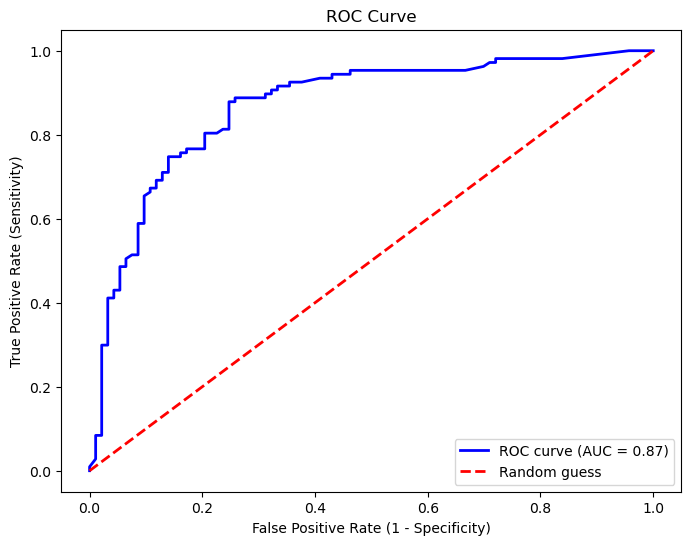

Optimal Threshold (Youden's J): 0.25892834329522496


<Figure size 640x480 with 0 Axes>

In [20]:
X_train, X_test, y_train, y_test = win_predict.train_test_split()

# Create logistic regression model
# Needed to increase the max iterations for GridSearchCV
lr = LogisticRegression(max_iter=200)

# Fit training data
lr.fit(X_train, y_train)

# Predict if the game is a win or a loss on the test data
y_pred = lr.predict(X_test)

# Confidence the model has in each of its predictions
y_prob = lr.predict_proba(X_test)[:, 1]

lr_tuner = LogisticRegressionTuner(X_train, X_test, y_train, y_test)
optimal_threshold = lr_tuner.get_optimal_threshold(y_prob)

# Hyperparameter Tuning
Now that we have determined an optimal acceptance threshold, we can tune the hyperparamter C (the inverse of regularization stregth).

In [22]:
# Define hyperparameter grid for grid search
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}

best_params, accuracy = lr_tuner.tune_parameters(lr, param_grid)

Best hyperparameters: {'C': 0.1}
Accuracy on the test set: 0.83


# Test model on new data
Now that we have finished tuning the hyperparameters for our logistic regression model, we can test its performance on an entirely new dataset. This second dataset is handled the same way as the first, starting with a cleaning of the data. We then train a logistic regression model on the original dataset with C = 0.1, and test its predictive capabilities on our new dataset yielding an accuracy score of 84.5%. We can still potentially squeeze out more performance by tuning the optimal threshold for this specific case. By doing so, we see a slight improvement with a new accuracy score of **84.8%**.

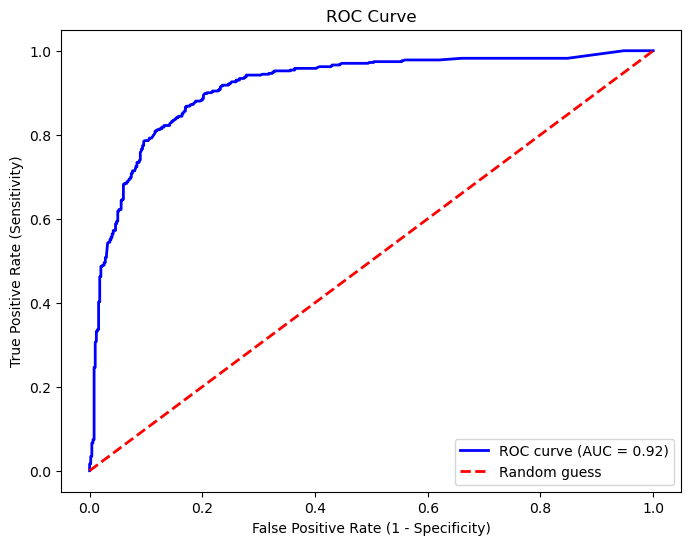

Optimal Threshold (Youden's J): 0.3175499030252782

Original accuracy score: 0.845
Accuracy score with optimal threshold: 0.848


<Figure size 640x480 with 0 Axes>

In [24]:
file_path2 = 'test_objectives_data.parquet.gzip'

win_predict_test = WinPredictionTrainingPipeline(file_path2, 'win')
win_predict_test.read_parquet_file()
win_predict_test.parquet_to_pandas()
win_predict_test.get_categorical_features()
win_predict_test.clean_data()
win_predict_test.feature_target_split()
X_data_test = win_predict_test.get_X_data()
y_data_test = win_predict_test.get_y_data()

X_data_test.pop('hordeKills_2')
win_predict_test.set_X_data(X_data_test)

lr_optimal = LogisticRegression(C = 0.1)
lr_optimal.fit(X_train, y_train)

y_pred_test = lr_optimal.predict(X_data_test)
y_prob_test = lr_optimal.predict_proba(X_data_test)[:, 1]

accuracy_test = accuracy_score(y_data_test, y_pred_test)

test_tuner = LogisticRegressionTuner()
optimal_threshold_test = test_tuner.get_optimal_threshold(y_prob_test, y_data_test)

y_pred_optimal = (y_prob_test >= optimal_threshold_test)

new_accuracy_test = accuracy_score(y_data_test, y_pred_optimal)
print(f"\nOriginal accuracy score: {accuracy_test}")
print(f"Accuracy score with optimal threshold: {new_accuracy_test}")